# Project ADA Final notebook

### [Fast start](#second start) (Skips the cleaning part)

**Importing libraries**

We mainly used `Pandas` in order to do exploratory analysis. For mathematical operations, and arrays, we used `NumPy`. For plotting we used `Matplotlib` and `Seaborn`, and finally for the cleaning part with the country names, the packagings and the labels to translate, we used `PyCountry`, `gettext`, `translate` and `re`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry as pc
import gettext as gt
import re
from translate import Translator

## Loading and first exploration

**Loading the dataset**

In [2]:
DATA_FOLDER = 'data/'

In [3]:
df = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv', sep="\t", encoding="utf-8", low_memory=False)

In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1523440823,2018-04-11T10:00:23Z,Salade de carottes râpées,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see from here that there is a lot of information, and it seems that there is a lot of NaN values for certain columns.

More precisely, we can compute the number of columns in the dataframe:

In [5]:
print('Number of columns in the DataFrame:', df.columns.size)

Number of columns in the DataFrame: 173


There are many features, but we definitely won't work with all of them for the purpose of this project.

As we explore the dataset, we will only keep a few columns from all those we have at our disposal.

**NaN proportion for each column**

As mentioned earlier, it looks like there are many NaN values. Let's see that. Here we compute the proportion of NaN values for each columns, and only plot the columns that have less than 50% of NaNs.

Number of columns that have a proportion of NaN less than 50%:  30 / 173 columns.


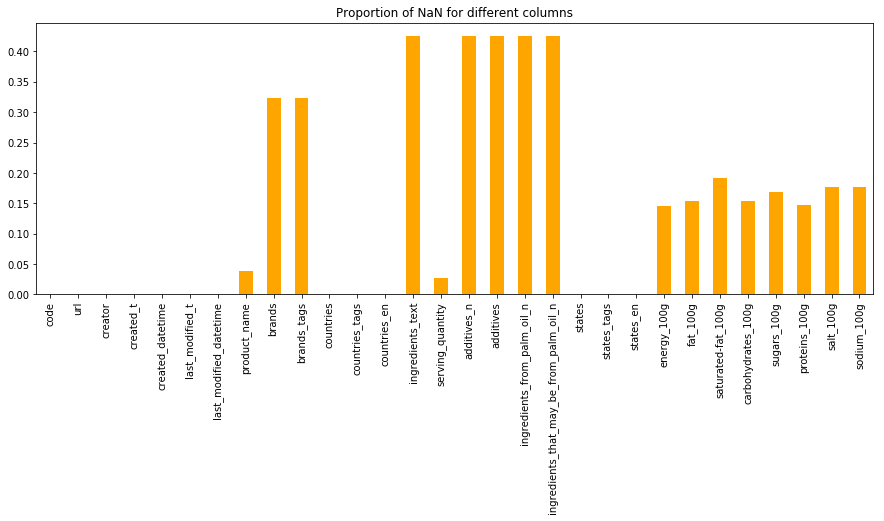

In [6]:
nan_proportion = df.isnull().mean(axis=0)
nan_proportion_50 = nan_proportion[nan_proportion<0.5]
print('Number of columns that have a proportion of NaN less than 50%: ', 
      nan_proportion_50.size, '/', df.columns.size, 'columns.')

plt.figure(figsize=(15, 5))
nan_proportion_50.plot(kind='bar', color='orange')
plt.title('Proportion of NaN for different columns')

plt.show()

Quite surprising! Actually, only 30 columns are more than half filled on the 173 that we have at our disposal. This suggest that maybe we will need to review some of things we planned to do because of the missing values. Indeed, if a huge amount of values are missing, we won't get very precise insights about the data for these columns.

**Choosing the columns to keep**

Now let's see with what columns we are going to work with. Of course, we keep the information about the products such as the name, brand, url. 

Then we also want to keep the information about the countries, since it was one of the main focus of the project.

We will also keep all those related to the composition of the products (serving quantity, additives, fat, sugar, ...) as it will help us get insights about which country eats what.

In [7]:
# Columns that we keep for the exploratory analysis
cols = ['product_name', 'url', 'brands_tags', 'countries_en', 'origins', 'serving_quantity', 'additives_n', 
        'fat_100g', 'carbohydrates_100g', 'sugars_100g', 
       'proteins_100g', 'salt_100g', 'labels', 'packaging']

# Filter to only keep the columns we need
df = df[cols]

## Cleaning the dataset

**Cleaning the countries columns**

The columns `origins` and `countries_en` need a lot of cleaning to be usable later.

In [8]:
# Put everything in lowercase in order to have more consistency
df['countries_en'] = df['countries_en'].str.lower() 
df['origins'] = df['origins'].str.lower()
df['packaging'] = df['packaging'].str.lower()
df['labels'] = df['labels'].str.lower()

For outlier exploration, we defined a function to check wether the columns with countries are in the right format or not.

In [9]:
def countries_format_check(df, column):
    """Counts the number of occurences of some unexpected 
    types or values for entries in the specified column
    """
    
    counter_wrong_type = 0
    counter_empty_string = 0
    counter_nan = 0

    for entry in df[column]:
        if not(type(entry) is str):
            counter_wrong_type += 1
        elif entry == "":
            counter_empty_string += 1
            
        if entry != entry: # entry is NaN <=> entry != entry
            counter_nan += 1

    print("%d values in " %counter_wrong_type + column + " are not of type 'str'")
    print("%d values in " %counter_nan + column + " are nan")
    print("%d values in " %counter_empty_string + column + " are empty strings")

In [10]:
countries_format_check(df, 'countries_en')

543 values in countries_en are not of type 'str'
543 values in countries_en are nan
0 values in countries_en are empty strings


As we can see, some entries in `countries_en` are actually not strings. Actually, these outliers are always NaN (so they have float type). Since this value is needed we can drop these samples.

In [11]:
countries_format_check(df, 'origins')

639722 values in origins are not of type 'str'
639722 values in origins are nan
0 values in origins are empty strings


In `origins`, it is even worse. We rarely even have anything else than a NaN. When we are interested in the origins of a product, we need to drop these outliers. Otherwise we need to keep them (or we would lose too much data).

**Exploding the countries columns**

In [12]:
def explode_dataframe(df, column, separator):
    """ Duplicates the rows of the input DataFrame df, by splitting on 'separator' the string contained in 'column'
        For example, when using this function on column C, with separator ',' on the following DataFrame
            A  B  C
        1   1  2  a,b
        2   3  4  c,d,e
    
        We expect a return value like this:
            A  B  C
        1   1  2  a
        1   1  2  b
        2   3  4  c
        2   3  4  d
        2   3  4  e
    """
    
    # Helper function that duplicates a single 'row' and appends the result to 'rows'
    def explode_row(row, rows):
        splitted_string = row[column].split(separator)
        for s in splitted_string:
            new_row = row.to_dict()
            new_row[column] = s
            rows.append(new_row)
    
    rows = []
    df.apply(lambda row : explode_row(row, rows), axis=1)

    new_df = pd.DataFrame(rows)
    return new_df

First, we split `countries_en` and `origins`, since they may contain more than one country.

In [13]:
df_with_countries = explode_dataframe(df.dropna(subset=['countries_en']), 'countries_en', ',')
print('New shape of our DataFrame:', df_with_countries.shape)

New shape of our DataFrame: (710512, 14)


As we can see, we end up with quite a lot more data when splitting to get all the countries separated.

In [14]:
df_with_origins = explode_dataframe(df_with_countries.dropna(subset=['origins']), 'origins', ',')
print('Shape of the DataFrame with the origins:', df_with_origins.shape)

Shape of the DataFrame with the origins: (60114, 14)


But due to the number of NaN values in `origins`, we have a lot less data in `df_with origins`. Now we'll either use `df_with_origins` when we need the origins, or df when we don't need the origins. Thus we can drop `origins` in `df`.

In [15]:
df_with_countries = df_with_countries.drop(['origins'], axis=1)
df = df.drop(['countries_en', 'origins'], axis=1)

**Formatting the countries columns**

Now the main issue is that the format of these strings is not consistent at all. Some country names are written in french, some are in english, etc... Even in `countries_en` (where everything is supposed to be written in english, some entries are in french or in some other language, or even some kind of code). In `origins` it's even more frequently in some other language than english. Also some are very specific (country + region + county for example), and we will not be interested in so much spatial detail. We also still have outliers from which we cannot retrieve the country it corresponds to (like strings that do not even contain any spatial information).

First we load the main used languages that we will translate from. That choice is based on a previous result where we have got an idea of the countries of the products. We then have chosen the 12 top languages in those results. English is not in the list because we will translate from it.

In [16]:
languages = ['french', 'german', 'spanish', 'italian', 'dutch', 'russian', 'swedish',
             'portuguese', 'danish', 'romanian', 'hungarian']

In [17]:
country_translations = []
for language in languages:
    country_translations.append(gt.translation('iso3166', pc.LOCALES_DIR, languages=[language]))

Now we need to be able to read the countries lists from PyCountry. We defined 4 functions for that.

In [18]:
# Read the country names in english
def read_country_names_en():
    country_names = []
    for country in pc.countries:
        country_names.append(country.name.lower())
    return country_names

# Read the country names translated in another language
def read_country_names_translated(language):
    country_names = []
    for country in pc.countries:
        country_names.append(language.gettext(country.name).lower())
    return country_names

# Read the country alpha2 codes
def read_country_alpha2s():
    country_names = []
    for country in pc.countries:
        country_names.append(country.alpha_2.lower())
    return country_names

# Read the country alpha3 codes
def read_country_alpha3s():
    country_names = []
    for country in pc.countries:
        country_names.append(country.alpha_3.lower())
    return country_names

Now we can apply that to get a dictionary to translate the different country names or codes into the english country names. We also manually defined a dictionary for the strings with the most occurences that the other dictionaries could not translate (like regions of some countries, or country codes that are not the actual alpha2 code of the country it is supposed to represent).

In [19]:
# Transform a list of keys and a list of values to a dictionary and add it to the dictionary list
def append_dict(dicts_list, keys_list, values_list):
    dicts_list.append(dict(zip(keys_list, values_list)))

# Concats all the dictionaries to one single dictionary
def concat_dicts(dicts_list):
    total_dict = {}
    for i in range(0, len(dicts_list)):
        total_dict = {**total_dict, **dicts_list[i]}
    return total_dict

In [20]:
country_names_dicts = []
countries_en = read_country_names_en() # Values to which the names will map (english version of the country names)

append_dict(country_names_dicts, countries_en, countries_en)
for translation in country_translations:
    append_dict(country_names_dicts, read_country_names_translated(translation), countries_en)
append_dict(country_names_dicts, read_country_alpha2s(), countries_en)
append_dict(country_names_dicts, read_country_alpha3s(), countries_en)

manual_dict = {
'en' : 'united kingdom',
'uk' : 'united kingdom',
'czech republic' : 'czechia',
'south korea' : 'korea, republic of',
'eua' : 'united states',
'e.u.a.' : 'united states',
'palestine' : 'palestine, state of',
'syria' : 'syrian arab republic',
'bretagne' : 'france',
'normandie' : 'france',
'sud-ouest' : 'france',
'lait origine france' : 'france',
'ecosse' : 'united kingdom',
'provence' : 'france',
'equateur' : 'ecuador',
'thailande' : 'thailand',
'sud-ouest de la france' : 'france',
'république dominicaine' : 'dominican republic',
'ciudad de méxico' : 'mexico',
'sicile' : 'italia',
'écosse' : 'united kingdom',
'camargue' : 'france',
'bourgogne' : 'france',
'corse' : 'france',
'alsace' : 'france',
' españa' : 'spain',
'bolivie' : 'bolivia, plurinational state of',
'porc origine france' : 'france',
'fr:lait de france' : 'france',
'pays de la loire' : 'france',
'aquitaine' : 'france',
'québec' : 'canada',
'ardèche' : 'france',
'andalucía' : 'spain',
'agriculture france' : 'france',
'angleterre' : 'united kingdom',
'ile de la réunion' : 'france',
'etats-unis' : 'united states',
'val de loire' : 'france',
'rhône-alpes' : 'france',
'aveyron' : 'france',
'auvergne' : 'france',
'california' : 'united states',
'franche-comté' : 'france',
'savoie' : 'france',
'russie' : 'russian federation',
'alaska' : 'united states',
'fr:deutschland' : 'germany',
'ch:suisse' : 'switzerland',
'loire-atlantique' : 'france',
'de:allemagne' : 'germany',
'fr:schweiz' : 'switzerland',
'fr:frankreich' : 'france',
'republic of macedonia' : 'macedonia, republic of',
'fr:quebec' : 'canada',
'fr:dom-tom' : 'france',
'democratic republic of the congo' : 'congo, the democratic republic of the',
'republic of the congo' : 'congo, the democratic republic of the'}
country_names_dicts.append(manual_dict)
        
countries_dictionary = concat_dicts(country_names_dicts)

We can now easily define an efficient function that translates a country to the english name.

In [21]:
# Translate the parameter 'word' to its english name, or NaN if it is not found in the dictionary.
def translate(word, dictionary):
    return dictionary.get(word, np.NaN)

# Translate a whole column of a DataFrame with a dictionary.
def translate_column(df, column, dictionary):
    # Translate every word in the column
    df[column] = df[column].map(lambda word : translate(word, dictionary))
    # Get rid of the new NaN values induced by impossibility to translate
    df = df.dropna(subset=[column])
    return df

For example, when used on 'allemagne', and on 'zzzzzz' (something we can't translate) we get:

In [22]:
print(translate('allemagne', countries_dictionary))
print(translate('zzzzzz', countries_dictionary))

germany
nan


In [23]:
# Translate the 'countries_en' column in df
df_with_countries = translate_column(df_with_countries, 'countries_en', countries_dictionary)

# Translate the 'countries_en' and the 'origins' columns in df_with_origins
df_with_origins = translate_column(df_with_origins, 'countries_en', countries_dictionary)
df_with_origins = translate_column(df_with_origins, 'origins', countries_dictionary)

In [24]:
print('Shape of our DataFrame with the countries:', df_with_countries.shape)
print('Shape of the DataFrame with the origins:', df_with_origins.shape)

Shape of our DataFrame with the countries: (709581, 13)
Shape of the DataFrame with the origins: (38952, 14)


As we can see, a few rows were lost in `df_with_countries` (~600 out of ~728k), but many were lost in `df_with_origins` (~22k out of ~62k) because the format of `origins` is very inconsistent.

We can now save the new DataFrames for faster loading next time.

In [25]:
df.to_csv(path_or_buf=DATA_FOLDER + 'df.csv', sep="\t", encoding="utf-8", index=False)
df_with_countries.to_csv(path_or_buf=DATA_FOLDER + 'df_with_countries.csv', sep="\t", encoding="utf-8", index=False)
df_with_origins.to_csv(path_or_buf=DATA_FOLDER + 'df_with_origins.csv', sep="\t", encoding="utf-8", index=False)

## The notebook can be started here for faster computation <a id='second start'></a>

Reload the save and other variables and some imports:

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from translate import Translator

DATA_FOLDER = 'data/'

languages = ['french', 'german', 'spanish', 'italian', 'dutch', 'russian', 'swedish',
             'portuguese', 'danish', 'romanian', 'hungarian']

df = pd.read_csv(DATA_FOLDER + 'df.csv', sep="\t", encoding="utf-8", low_memory=False)
df_with_countries = pd.read_csv(DATA_FOLDER + 'df_with_countries.csv', sep="\t", encoding="utf-8", low_memory=False)
df_with_origins = pd.read_csv(DATA_FOLDER + 'df_with_origins.csv', sep="\t", encoding="utf-8", low_memory=False)

**Packaging and Labels columns formatting**

For the `packaging` and `labels` columns, it's even more complicated.
Imagine if a product has packaging `plastic, bag`. Then exploding the packaging would result in two different rows, one with packaging `plastic`, the other with packaging `bag`. Since we want to make statistics on the packagings, this would give erroneous proportion for each of them.

For the country-related columns, it was not an issue because we are not interested in the proportion of products produced in each country, but we would rather want to make statistics on other interesting information for each country.

Our decision is to define different accessors to get each interesting label and each interesting packaging type in the dataset. With this approach we will avoid the problem stated above. The results will still be slightly biased, because we only consider those written in one of the top languages. We will not give any country-specific result for the countries that do not have enough datapoints, so this bias will be very small.

First we define a function that returns a boolean mask for a dataframe, computed from wether or not the input string is contained in each row (in the specified column).

In [27]:
def contains_str(df, column, string):
    return df[column].str.contains(string, na=False, flags=re.IGNORECASE)

Now we can use this function to define a higher level one, that returns all the elements of the input dataframe such that at a specified column, at least one of the `included_strings` parameter is contained, and none of the `excluded_strings` parameter is contained.

In [28]:
def filter_str_column(df, column, included_strings, excluded_strings=[]):
    df = df.reset_index(drop=True)
    boolean_mask = pd.Series(np.full((len(df)), False, dtype=bool))
    for string in included_strings:
        boolean_mask = boolean_mask | contains_str(df, column, string)
    for string in excluded_strings:
        boolean_mask = boolean_mask & ~contains_str(df, column, string)
    return df[boolean_mask]

We also defined a function to translate a word to a list of translations in the input languages. This was used to quickly make translations for the labels and packagings that we are interested into, but since it is API-based (and thus slow) we hard-coded the translations (so `multi_translate` is not used anymore). We also simplified them sometimes since we only need the string to be included (so a prefix works as well).

In [29]:
def multi_translate(word, languages):
    translations = []
    for language in languages:
        translator = Translator(to_lang=language)
        translations.append(translator.translate(word))
        
    return translations

The final keywords are here:

In [30]:
# Usual words or prefixes for organic products
# The regex \\bAB\\b is to find the acronym AB alone (a popular organic label in France)
organic_included = ['bio', 'organi', 'orgáni', 'Økologisk', 'szerves', '\\bAB\\b']

# Most of the gluten free products contain the word 'gluten' in their labels, or 'glutine' in Italian
# 1 product is labeled "avec gluten" so we have to get rid of it
gluten_free_included = ['gluten', 'glutine', 'клейковина', 'glúten', 'sikér']
gluten_free_excluded = ['avec gluten', 'mit gluten', 'con gluten', 'con glutine',
    'met gluten', 'с глютеном', 'med gluten', 'com glúten', 'cu gluten', 'a glutén']

# Most popular ways of writing the vegan label
# Some products are labeled "no vegan" so we have to get rid of them
vegan_included = ['vega', 'végétalien', 'vegetalien', 'végane']
vegan_excluded = ['no vegan']

# Containing 'halal' is necessary and sufficient for a product to be halal
halal_included = ['halal', 'xаляльное', 'helal']

# Fair trade is written down in different ways in the dataframe, so we have to gather most of them
fair_trade_included = ['commerce équitable', 'fairtrade', 'fair trade', 'fair-trade', 'commercio equo e solidale', 
    'eerlijke handel', 'честная торговля', 'feira comercial', 'comerț echitabil', 'tisztességes üzlet']

# Usual words or prefixes for plastic in the most used languages
plastic_included = ['plast', 'kunststof', 'plástico', 'пластик', 'műanyag']

# Usual words or prefixes for cardboard or paper in the most used languages
cardboard_included = ['cart', 'cardboard', 'karton', 'Картон', 'pap', 'бумага', 'hârtie']

# Usual words or prefixes for glass in the most used languages
glass_included = ['verre', 'glas', 'vidrio', 'стекло', 'sticlă', 'pohár']

# Usual words or prefixes for metal or aluminium in the most used languages
metal_included = ['metal', 'métal', 'металл', 'fém', 'alumini', 'alumíni', 'алюминий', 'can']

With all of that, we can super easily define functions to get all the elements of the dataframe that match what we are interested into. Most of the times we only need to include the translations of the info we want to have, but sometimes we also have to specifically exclude some results. The values of `vegan_excluded` and `gluten_free_excluded` explain this very well.

In [31]:
def bio_label(df):
    return filter_str_column(df, 'labels', organic_included)

def vegan_label(df):
    return filter_str_column(df, 'labels', vegan_included, vegan_excluded)

def gluten_free_label(df):
    return filter_str_column(df, 'labels', gluten_free_included, gluten_free_excluded)

def halal_label(df):
    return filter_str_column(df, 'labels', halal_included)

def fair_trade_label(df):
    return filter_str_column(df, 'labels', fair_trade_included)

def plastic_packaging(df):
    return filter_str_column(df, 'packaging', plastic_included)

def cardboard_packaging(df):
    return filter_str_column(df, 'packaging', cardboard_included)

def glass_packaging(df):
    return filter_str_column(df, 'packaging', glass_included)

def metal_packaging(df):
    return filter_str_column(df, 'packaging', metal_included)

## Exploratory Analysis

**Import - Export**

As a first analysis, we will try to visualize which countries import and export, for the main countries in the dataset.

Now let's get the destination and origin countries for the products, and try to first visualize which are the top destination countries:

In [32]:
dest_count = df_with_countries['countries_en'].value_counts()

We plot below the top-25 destination countries. Note that since France has a significantly higher number of products (this is a french dataset), we also plot in the log scale.

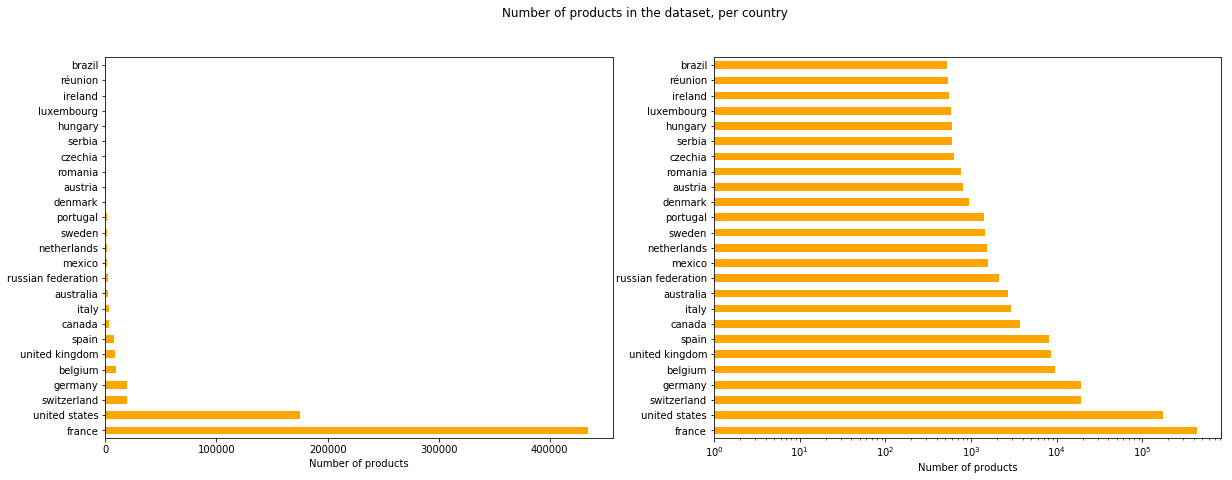

In [33]:
#Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

#Plot the count of the products for each destination country
dest_count[:25].plot(kind='barh', color='orange', ax=ax1)
ax1.set_xlabel('Number of products')

#Plot again in log scale
dest_count[:25].plot(kind='barh', color='orange', ax=ax2, log=True)
ax2.set_xlabel('Number of products')

f.suptitle('Number of products in the dataset, per country')
plt.show()

Not surprinsingly, the top countries are mainly those from Europe (again, the dataset focuses a lot on France and Europe), but we can also see the US, Canada and Mexico for example.

***In the remaining part of the notebook, we decided to focus our analysis on the countries that have the most products in their inventory, so that we can do the analysis on countries that have the most data points.***

So we will keep those top countries, and we will do the analyses on the first 15 of them. This will also help for the current visualizations that are mostly in bar charts (impossible to read if there are too many countries).


In [34]:
top_15 = df_with_origins['countries_en'].value_counts()[:15].index

In [160]:
def compute_import_export(df, country):
    exporting_to = df[df['origins'] == country]
    export_count = exporting_to.groupby('countries_en').size()
    top_export = export_count.nlargest(10)
    top_export = top_export.drop(labels=[country])
    
    importing_from = df[df['countries_en'] == country]
    import_count = importing_from.groupby('origins').size()
    top_import = import_count.nlargest(10)
    top_import = top_import.drop(labels=[country])
    
    percentage_local = (import_count[country]*2) / (import_count.sum() + export_count.sum())
    
    return top_export, top_import, percentage_local

def plot_import_export(df, country):
    e, i, p = compute_import_export(df, country)
    
    plt.figure(figsize=(20, 15))
    plt.subplot(221)
    e.plot(kind='barh', color='orange')
    plt.title('Top countries where '+ country + ' exports')
    plt.xlabel('Number of products')
    plt.ylabel('')
    
    plt.subplot(222)
    i.plot(kind='barh', color='orange')
    plt.title('Top countries from which '+ country + ' imports')
    plt.xlabel('Number of products')
    plt.ylabel('')
    
    
    plt.subplot(223)
    plt.pie([p, 1-p], labels=[country, 'others'], autopct='%1.1f%%')
    plt.title('Proportion of products that are local/non-local')
    plt.show()
    

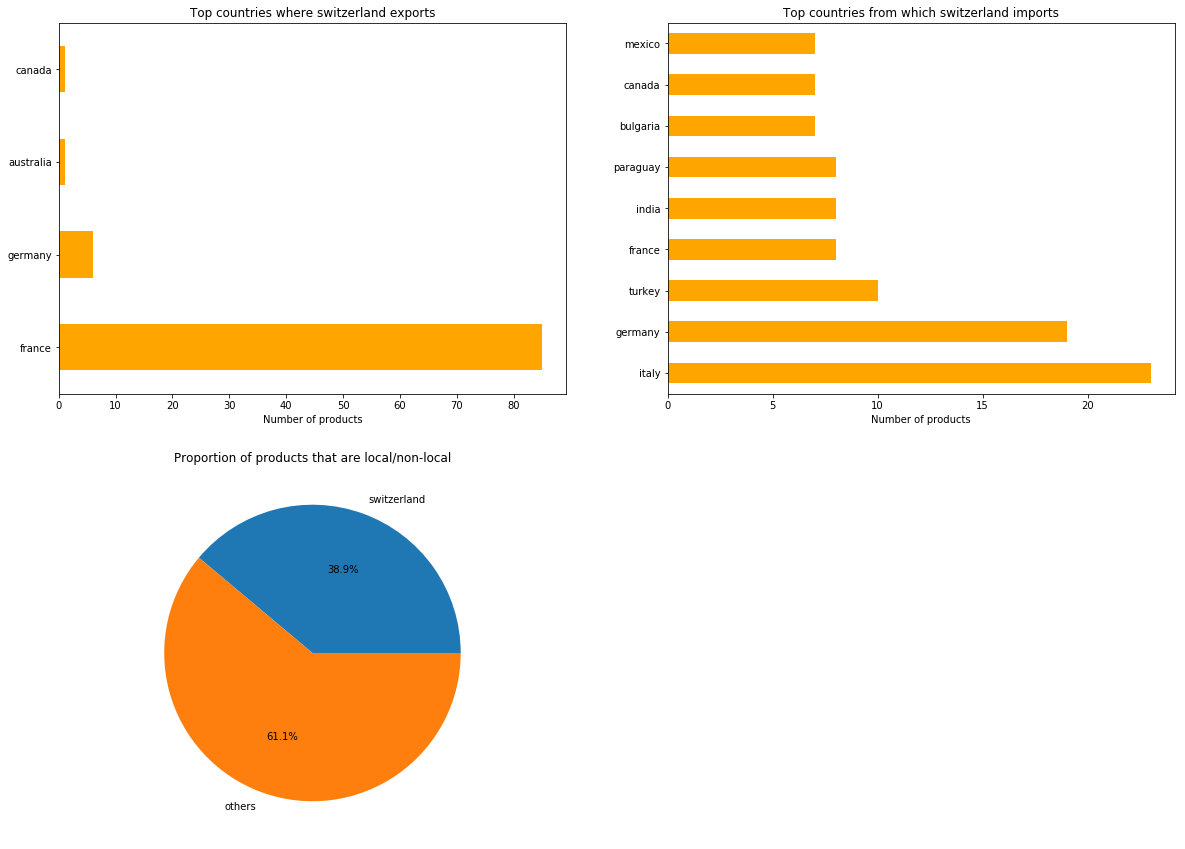

In [162]:
plot_import_export(bio_label(df_with_origins), 'switzerland')

Here, we will visualize the origins and destinations, for the top 15 countries in the destinations. We chose to represent this information as a heatmap. 
For each pair of countries, we compute the number of food products for that pair and add one to the corresponding cell in a matrix representing those pairs.

After the matrix is filled with the counts of the different pairs, we use the `heatmap()` function of Seaborn to visualize the results.

In [35]:
def compute_heatmap(df, countries):
    """Given a dataframe, compute a 
    heatmap matrix for import-export
    analysis of the given countries"""
    
    # Create the matrix that will contain the counts
    matrix = pd.DataFrame(np.zeros((countries.size, countries.size)), index=countries, columns=countries)

    # Fill in the matrix (for the top countries)
    for idx, row in df.iterrows():
        origin = row['origins']
        destination = row['countries_en']
        if destination in countries and origin in countries:
            matrix.at[origin, destination] += 1
    return matrix

In [36]:
def plot_heatmap(matrix):
    """Plot the given matrix as a heatmap"""
    
    # Create subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Use Seaborn to plot a heatmap using the matrix
    sns.heatmap(matrix, linewidth=0.5, cmap='Reds', ax=ax1)
    ax1.set_ylabel('Origin Country')
    ax1.set_xlabel('Destination Country')

    # Plot again in log scale
    sns.heatmap(np.log(matrix+1), linewidth=0.5, cmap='Reds', ax=ax2)
    ax2.set_ylabel('Origin Country')
    ax2.set_xlabel('Destination Country')

    f.suptitle('Import-Export count between countries')
    plt.show()

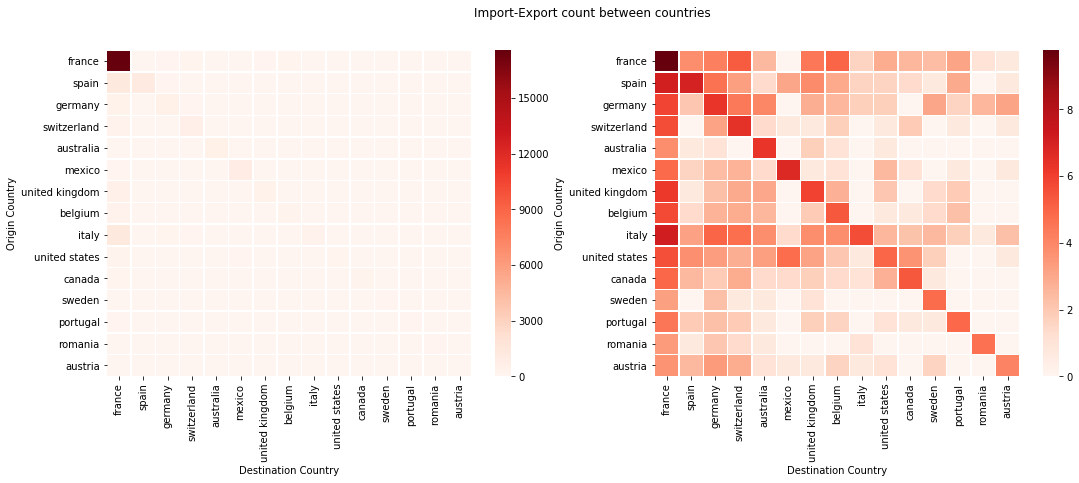

In [37]:
plot_heatmap(compute_heatmap(df_with_origins, top_15))

As France has a count that is a lot larger, we also plotted on the right with a log scale to get better insights. What we see from this plot is very interesting. 

With this dataset, it looks like many countries actually produce their own food (look at the diagonal). Again, as France has always more data in this dataset, we see that France import and export to many countries. This may definitely be biased, and that's why we prefer to focus also on the other countries.

Spain, Mexico, Australia and UK also produce a lot of their own food. As big exporters, we spot Spain, Germany, Italy, which makes sense for Europe, and we have the US for the American countries. As importers, the plot suggests that Germany, Switzerland, Australia and UK are the main ones.

**Which countries sell what? (in terms of composition)**

In this part, we focus on an interesting analysis that aim to see which are the top countries that eat with the biggest number of additives, the most quantity of sugar, salt, fat or proteins.

This may be a good indicator of the quality of the products sold in our top countries. Are they healthy or not?

In order to compute that, we will make use of the columns below, reunited in a list called `composition_cols`. Here again, we will need to use the countries where the products are sold.

In [13]:
# Get the columns we need to do the analysis
composition_cols = ['additives_n', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 
                    'proteins_100g', 'salt_100g']

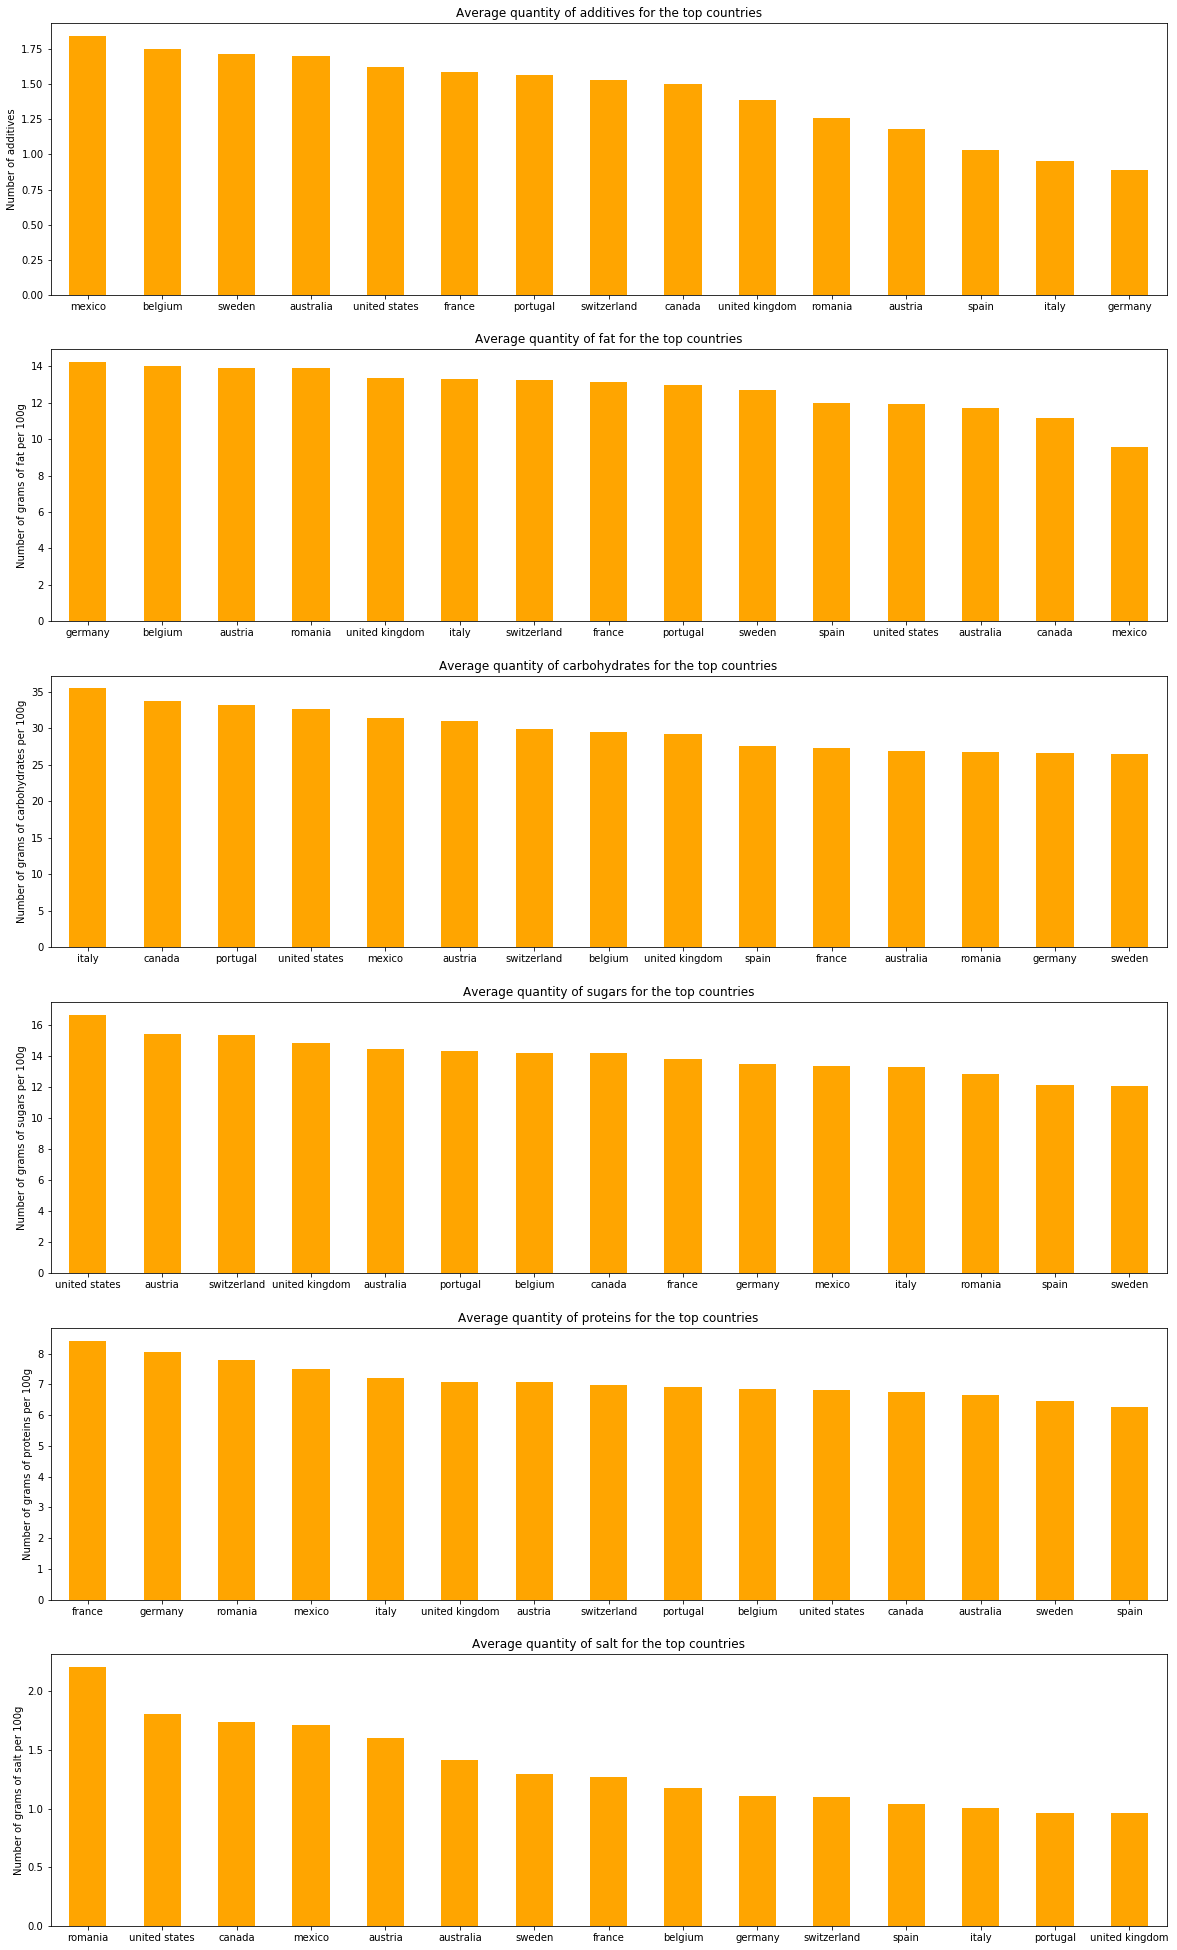

In [14]:
# Create subplot for the visualization
f, axarr = plt.subplots(len(composition_cols), 1, figsize=(20, 35))

# For each composition property (sugar, fat, ...)
for i, comp in enumerate(composition_cols):
    
    # Get the composition we want
    df_temp = df_with_countries[['countries_en', comp]]
    
    # We remove incorrect values for "_100g" columns
    if comp != 'additives_n':
        df_temp = df_temp[df_temp[comp] < 100]
    
    # We group by country, and compute the mean for the columns we need
    df_temp = df_temp.groupby('countries_en').mean()
    
    # Plot a bar chart for our top 15 countries
    df_temp.loc[top_15].sort_values(by=comp, ascending=False).plot(kind='bar', legend=None,
                                                        color='orange', rot=0, ax=axarr[i])
    
    # Get the name of the column without the "_100g" or "_n"
    comp_name = comp.split('_', 1)[0]
    
    # Set the axis titles depending on the columns
    if comp == 'additives_n':
        axarr[i].set_ylabel('Number of additives')
    else:
        axarr[i].set_ylabel('Number of grams of ' + comp_name + ' per 100g')
        
    # Set the title of the plots
    axarr[i].set_title('Average quantity of ' + comp_name + ' for the top countries')

plt.show()

It is hard to get any conclusions at this point, but we can see for example that in terms of sugar, the US has the largest amount.

For the salt, Romania is clearly first, and interestingly, the countries with the biggest quantities are mainly those from America. Does this imply that countries from America have products that are less healthy?

Again, it is hard to conclude yet, but the bar charts show interesting results. We believe that it will be easier to get more insights when we will have the visualization on the world map.

## Plans for the next steps of the project

**Plans for Milestone 3**

We have chosen the pdf report for the final submission.

For the 3rd milestone, we mainly plan to:

- Work on the formatting of `packaging` (in order to have everything in the same language, and matching precise names, like we did for the countries) &rarr; For the 2nd of December.

- Add visualization part (world map) For each country we plan to display some nutritional information about its products (from the columns of the form `information_100g`) &rarr; For the 2nd of December.

- Make some analysis on more labels (among vegan, gluten-free, halal and fair-trade) &rarr; For the 7th of December.

- Perform the machine learning part with the images for the BIO products (to see if there are recurrent patterns or dominant colors) &rarr; For the 7th of December

***Note that we already created a script in order to download the images of products with the BIO label. It can be found in the file `images_download.py`.***

- Complete the report &rarr; For the 14th of December

- Review our report before the final submission and enhance it &rarr; For the 16th of December


**Plans for the presentation**

For the presentation, we plan to:

- Give an introduction about the problem of how the food travels, packaging issues and nutrition concerns.

- Explain what our project was about (where the food comes from, biological products, packaging & nutritional values)

- Show and explain the different insights we got together with the maps of the world

- Show the machine learning part and indicate the patterns and dominant colors we found for the biological products